In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
#from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [3]:
data = pd.read_csv('compiled.csv')

In [4]:
# Data preparation
# ==============================================================================
data = data.copy()
data['time'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M')
#data = data.asfreq(freq='30T',method='pad')
exogenous_vars = ['pressure_f', 'cloud_cov_f', 'temp_f', 'wind_dir_f', 'wind_sp_f', 'covid', 'pub_hol', 'hour_sin','hour_cos','month_sin','month_cos']
target_var = ['load']
data = data[['time']+exogenous_vars+target_var]
data = data.set_index('time')
data = data.sort_index()
resampled_data = data.resample('30T').mean()
data = resampled_data.resample(rule='H', closed='left', label ='right').mean()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33600 entries, 2017-03-18 01:00:00 to 2021-01-16 00:00:00
Freq: H
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pressure_f   33600 non-null  float64
 1   cloud_cov_f  33600 non-null  float64
 2   temp_f       33600 non-null  float64
 3   wind_dir_f   33600 non-null  float64
 4   wind_sp_f    33600 non-null  float64
 5   covid        33600 non-null  float64
 6   pub_hol      33600 non-null  float64
 7   hour_sin     33600 non-null  float64
 8   hour_cos     33600 non-null  float64
 9   month_sin    33600 non-null  float64
 10  month_cos    33600 non-null  float64
 11  load         33600 non-null  float64
dtypes: float64(12)
memory usage: 3.3 MB


In [199]:
data.head(2)

,pressure_f,cloud_cov_f,temp_f,wind_dir_f,wind_sp_f,covid,pub_hol,hour_sin,hour_cos,month_sin,month_cos,load
time,,,,,,,,,,,,
2017-03-18 01:00:00,1011.0,3.0,14.0,307.0,2.0,0.0,0.0,0.000000,1.000000,1.0,6.120000e-17,1031471.628
2017-03-18 02:00:00,1011.0,4.0,14.0,215.0,2.0,0.0,0.0,0.258819,0.965926,1.0,6.120000e-17,1007205.578


In [5]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2017-03-19 00:00:00': '2021-01-15 23:00:00'].copy()
end_train = '2020-08-28 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2017-03-19 00:00:00 --- 2020-08-28 23:00:00  (n=30216)
Test dates       : 2020-08-29 00:00:00 --- 2021-01-15 23:00:00  (n=3360)


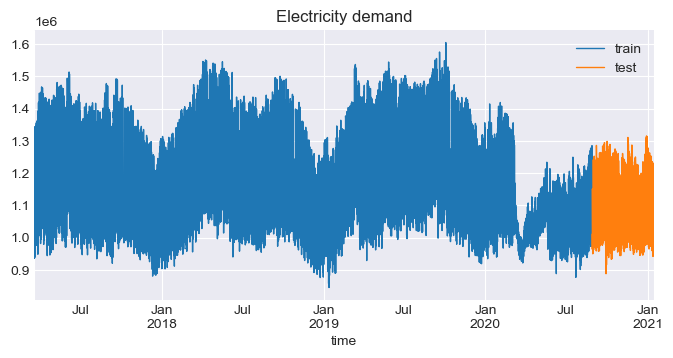

In [6]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data_train.load.plot(ax=ax, label='train', linewidth=1)
#data_val.load.plot(ax=ax, label='validation', linewidth=1)
data_test.load.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

Forecast

In [8]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 168,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:end_train, 'load'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 168 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-03-19 00:00:

Backtest

In [9]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['load'],
                          steps              = 48,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_train]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 30216
Number of observations used for backtesting: 3360
    Number of folds: 70
    Number of steps per fold: 48
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2017-03-19 00:00:00 -- 2020-08-28 23:00:00  (n=30216)
    Validation: 2020-08-29 00:00:00 -- 2020-08-30 23:00:00  (n=48)
Fold: 1
    Training:   2017-03-19 00:00:00 -- 2020-08-28 23:00:00  (n=30216)
    Validation: 2020-08-31 00:00:00 -- 2020-09-01 23:00:00  (n=48)
Fold: 2
    Training:   2017-03-19 00:00:00 -- 2020-08-28 23:00:00  (n=30216)
    Validation: 2020-09-02 00:00:00 -- 2020-09-03 23:00:00  (n=48)
Fold: 3
    Training:   2017-03-19 00:00:00 -- 2020-08-28 23:00:00  (n=30216)
    Validation: 2020-09-04 00:00:00 -- 2020-09-05 23:00:00  (n=48)
Fold: 4
    Training:   2017-03-19 00:00:00 -- 2020-08-28 23:00:00  (n=30216)
    Validation: 2020-09-0

  0%|          | 0/70 [00:00<?, ?it/s]

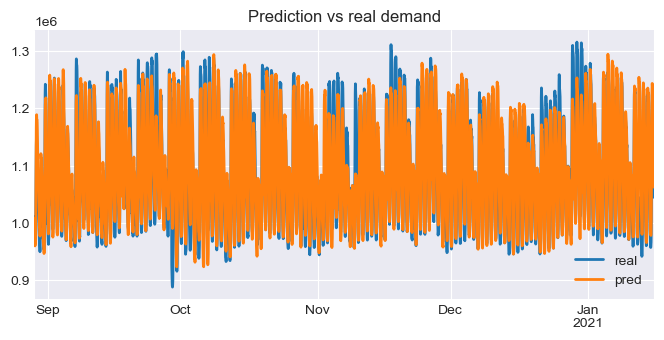

In [10]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'load'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [11]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 21974.022127338692


In [13]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 168, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [168, 5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49], [1, 2, 25, 24, 145, 168, 167, 49, 73, 121, 97, 144, 72, 120, 48, 96, 122, 50, 98, 74]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:, 'load'],
                   steps              = 48,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:end_train]),
                   refit              = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 50.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 21921.79278750047



In [14]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_absolute_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},21921.792788,0.001000
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},21922.151670,0.007743
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},21924.921249,0.059948
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},21946.092846,0.464159
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 3.593813663804626},22100.176702,3.593814
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 27.825594022071257},22928.487896,27.825594
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 215.44346900318823},24770.942115,215.443469
45,"[1, 2, 25, 24, 145, 168, 167, 49, 73, 121, 97,...",{'alpha': 27.825594022071257},24984.297794,27.825594
44,"[1, 2, 25, 24, 145, 168, 167, 49, 73, 121, 97,...",{'alpha': 3.593813663804626},25298.911616,3.593814
43,"[1, 2, 25, 24, 145, 168, 167, 49, 73, 121, 97,...",{'alpha': 0.46415888336127775},25554.310981,0.464159


In [208]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=0.001, random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 168 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017

  0%|          | 0/70 [00:00<?, ?it/s]

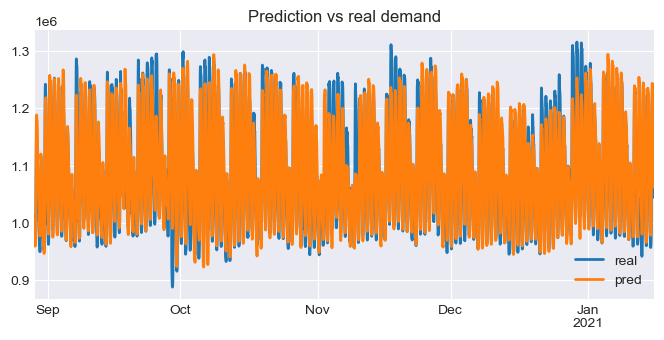

In [18]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['load'],
                          steps              = 48,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:end_train]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'load'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [19]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 21921.79278750047


In [211]:
forecaster.get_feature_importances().sort_values(by=['importance'], key=abs, ascending=False).head(20)

,feature,importance
0,lag_1,1.618323
1,lag_2,-0.670873
24,lag_25,-0.342780
23,lag_24,0.273187
144,lag_145,-0.270242
167,lag_168,-0.255592
166,lag_167,0.234649
48,lag_49,-0.201670
72,lag_73,-0.196188
120,lag_121,-0.181151


In [20]:
exogenous_columns = ['pressure_f', 'cloud_cov_f', 'temp_f', 'wind_dir_f', 'wind_sp_f']

In [21]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=0.001, random_state=123),
                 lags             = [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

forecaster.fit(y=data.loc[:end_train, 'load'], exog=data.loc[:end_train, exogenous_columns])
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=0.001, random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 168 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['pres

In [22]:
# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['load'],
                          exog                  = data[exogenous_columns],
                          steps                 = 48,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          #gap                   = 24,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

  0%|          | 0/70 [00:00<?, ?it/s]

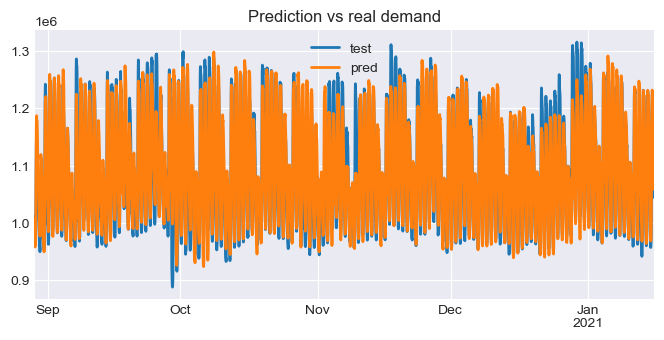

In [23]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'load'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [24]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'load'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")

Backtest error: 21604.481615648903
